---
    Title: filmtheater wordcount analysis with python
    Author: Bart Deijkers (bartdeijkers@gmail.com)
    Date: 2022-11-01
---

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/bartdeijkers/fth-text-mining/raw/master'
    os.system(f'wget {GIT_ROOT}/wordcount/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


In [2]:
%run "$BASE_DIR/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

In [3]:
from io import StringIO

import PyPDF2
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFPageInterpreter, PDFResourceManager
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

def convert_pdf_to_string(file_path):
	output_string = StringIO()
	with open(file_path, 'rb') as in_file:
		parser = PDFParser(in_file)
		doc = PDFDocument(parser)
		rsrcmgr = PDFResourceManager()
		device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
		interpreter = PDFPageInterpreter(rsrcmgr, device)
		for page in PDFPage.create_pages(doc):
			interpreter.process_page(page)

	return(output_string.getvalue())

In [4]:
pd.options.display.max_colwidth = 150 ###
file_path = f"{BASE_DIR}/data/" ### real location

df = pd.DataFrame()

for file in os.listdir(file_path):
    if file.endswith(".pdf"):
        text = convert_pdf_to_string(file_path+file)
        #concat dataframe with text
        date = file.split('.')[0]
        df = pd.concat([df, pd.DataFrame({'file':[file],'date':[date],'text': [text]})], ignore_index=True)


df['text'] = df['text'].str.replace('\n', ' ')
df['text'] = df['text'].str.replace('\t', ' ')
df['text'] = df['text'].str.replace('  ', ' ')

df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('[^a-z ]', '')
df['text'] = df['text'].str.replace('  ', ' ') # remove double spaces




In [5]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [6]:
import nltk
# not in book: make sure stop words are available
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('dutch'))

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
include_stopwords = {'min','zien'}
exclude_stopwords = {'beste'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

In [8]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [9]:
df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
from collections import Counter

counter = Counter()

_ = df['tokens'].map(counter.update)

In [12]:
pp.pprint(counter.most_common(5))

[('film', 391), ('the', 295), ('regie', 260), ('vanaf', 201), ('uur', 180)]


In [13]:
from collections import Counter ###
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].progress_map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [14]:
from wordcloud import WordCloud ###
from collections import Counter ###
from matplotlib import pyplot as plt


def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [15]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].progress_map(update)

    # create data frame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [16]:
freq_df = count_words(df)
idf_df = compute_idf(df)

freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

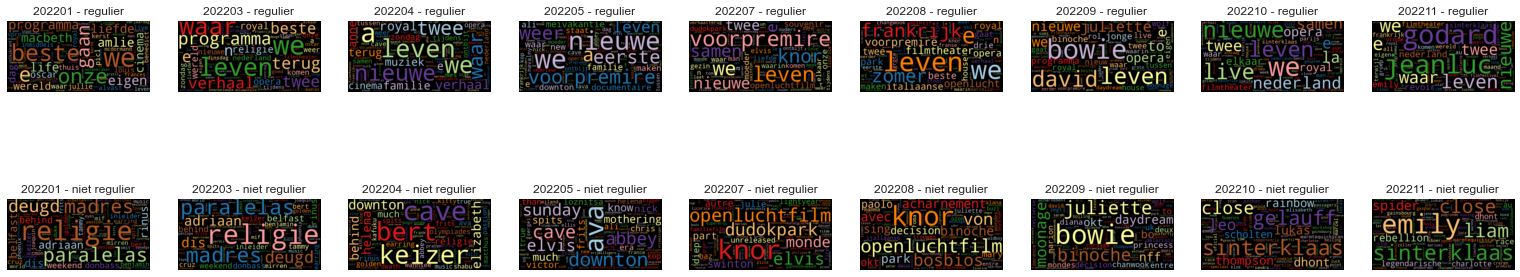

In [17]:
freq_202201 = count_words(df[df['date'] == '202201'])
freq_202203 = count_words(df[df['date'] == '202203'])
freq_202204 = count_words(df[df['date'] == '202204'])
freq_202205 = count_words(df[df['date'] == '202205'])
freq_202207 = count_words(df[df['date'] == '202207'])
freq_202208 = count_words(df[df['date'] == '202208'])
freq_202209 = count_words(df[df['date'] == '202209'])
freq_202210 = count_words(df[df['date'] == '202210'])
freq_202211 = count_words(df[df['date'] == '202211'])

freq_202201['tfidf'] = freq_202201['freq'] * idf_df['idf']
freq_202203['tfidf'] = freq_202203['freq'] * idf_df['idf']
freq_202204['tfidf'] = freq_202204['freq'] * idf_df['idf']
freq_202205['tfidf'] = freq_202205['freq'] * idf_df['idf']
freq_202207['tfidf'] = freq_202207['freq'] * idf_df['idf']
freq_202208['tfidf'] = freq_202208['freq'] * idf_df['idf']
freq_202209['tfidf'] = freq_202209['freq'] * idf_df['idf']
freq_202210['tfidf'] = freq_202210['freq'] * idf_df['idf']
freq_202211['tfidf'] = freq_202211['freq'] * idf_df['idf']

plt.figure(figsize=(27,6)) ###

stopwords_list=['film','films','hilversum','€','tijd','regie','regisseur','min.','uur','jaar','the','vanaf','januari', 'februari', 'maart', 'april', 'mei', 'juni', 'juli', 'augustus', 'september', 'oktober', 'november', 'december', 'jan','feb','mar','jun','jul','aug','sept','nov','dec','ma','di','wo','woe','don','do','vr','za','zo']

plt.subplot(2,9,1)###
wordcloud(freq_202201['freq'], title='202201 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,2)###
wordcloud(freq_202203['freq'], title='202203 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,3)###
wordcloud(freq_202204['freq'], title='202204 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,4)###
wordcloud(freq_202205['freq'], title='202205 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,5)###
wordcloud(freq_202207['freq'], title='202207 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,6)###
wordcloud(freq_202208['freq'], title='202208 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,7)###
wordcloud(freq_202209['freq'], title='202209 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,8)###
wordcloud(freq_202210['freq'], title='202210 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,9)###
wordcloud(freq_202211['freq'], title='202211 - regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,10)###
wordcloud(freq_202203['tfidf'], title='202201 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,11)###
wordcloud(freq_202203['tfidf'], title='202203 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,12)###
wordcloud(freq_202204['tfidf'], title='202204 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,13)###
wordcloud(freq_202205['tfidf'], title='202205 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,14)###
wordcloud(freq_202207['tfidf'], title='202207 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,15)###
wordcloud(freq_202208['tfidf'], title='202208 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,16)###
wordcloud(freq_202209['tfidf'], title='202209 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,17)###
wordcloud(freq_202210['tfidf'], title='202210 - niet regulier', stopwords=stopwords_list, max_words=100)

plt.subplot(2,9,18)###
wordcloud(freq_202211['tfidf'], title='202211 - niet regulier', stopwords=stopwords_list, max_words=100)




  0%|          | 0/9 [00:00<?, ?it/s]

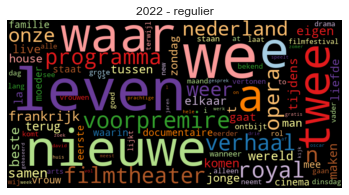

In [18]:
freq_2022 = count_words(df)
freq_2022['tfidf'] = freq_2022['freq'] * idf_df['idf']

wordcloud(freq_2022['freq'], title='2022 - regulier', stopwords=stopwords_list, max_words=100)



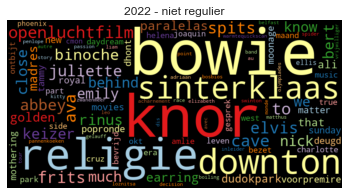

In [19]:
wordcloud(freq_2022['tfidf'], title='2022 - niet regulier', stopwords=stopwords_list, max_words=100)